# Hindcast nitrate summary

For upwelling manuscript, Moore-Maley et al. in prep

***

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yaml
from datetime import datetime, timedelta
from scipy import signal
from scipy.fftpack import fft, fftshift
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
plt.rcParams['font.size'] = 11

In [3]:
# Load subdomains and sections from YAML
with open('parameters.yaml') as f: subdomains, sections, _, _ = yaml.safe_load_all(f)

# Load netCDF files
HRDPS = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/SalishSeaCast/HRDPS_sections.nc')
ptrc = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/SalishSeaCast/SalishSea_1h_20150101_20181231_ptrc_T.nc')

In [4]:
# Load hindcast nitrate and wind along sections
window = signal.get_window('blackman', 73)
wind = signal.convolve(HRDPS.windspeed.values.mean(axis=1), window / sum(window), mode='same')
for sec, offset in zip(tqdm(sections), [77, 4, 54, 4]):
    sec['nitrate'] = {}
    yx = (sec['yx'][0]-subdomains['NO3'][2], sec['yx'][1][0]-subdomains['NO3'][0]+offset)
    sec['nitrate']['raw'] = ptrc.nitrate[(slice(None), 0) + yx].values
    sec['nitrate']['filtered'] = signal.convolve(sec['nitrate']['raw'], window / sum(window), mode='same')

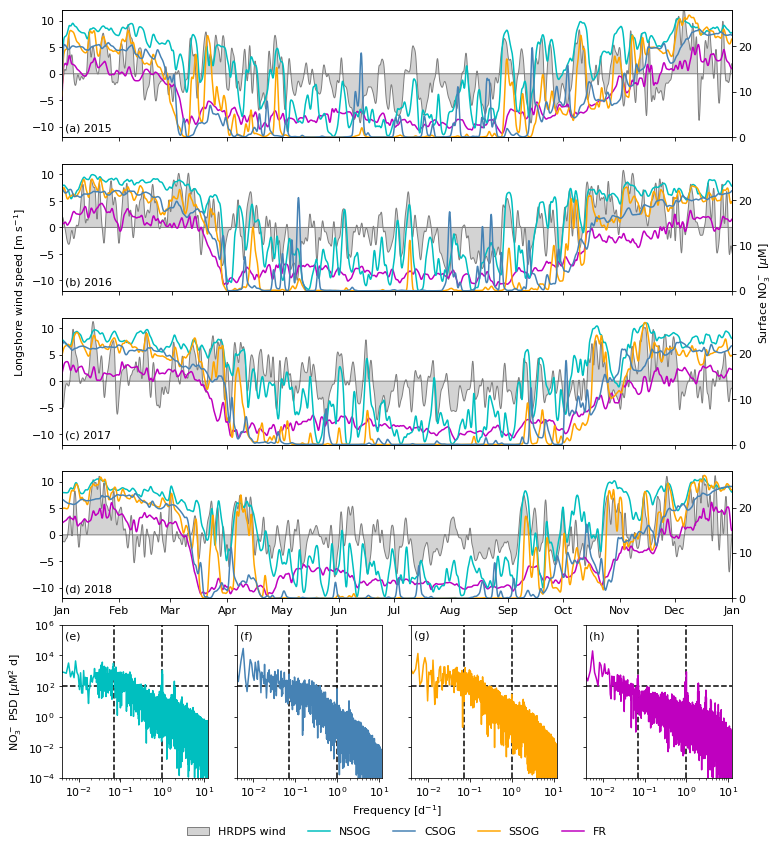

In [7]:
# Plot HRDPS and hindcast timeseries
fig = plt.figure(figsize=(12, 13))
gs = plt.GridSpec(5, 4, height_ratios=[1, 1, 1, 1, 1.2])
axs = [fig.add_subplot(gs[row, :]) for row in range(4)]
l = [0, 0, 0, 0, 0]
for ax, year in zip(axs, range(2015, 2019)):
    ax_right = ax.twinx()
    l[4] = ax.fill_between(HRDPS.time.values, wind, facecolor='lightgray', edgecolor='gray')
    for i in [0, 3, 1, 2]:
        sec = sections[i]
        l[i], = ax_right.plot(ptrc.time_counter, sec['nitrate']['filtered'], color=sec['c'], label=sec['name'])
    for axis, ylim, ylabel in zip([ax, ax_right], [[-12, 12], [-0.05, 28]], ['Longshore wind speed [m s$^{-1}$]', 'Surface NO$_3^-$ [$\mu$M]']):
        axis.set_ylim(ylim)
        if year == 2017: axis.set_ylabel(ylabel, y=1.2)
    ax.set_xlim([datetime(year, 1, 1), datetime(year+1, 1, 1)])
    ax.xaxis.set_major_locator(getattr(mdates, f'MonthLocator')())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.text(0.005, 0.05, f'({chr(year-1918)}) {year}', transform=ax.transAxes)
    if year < 2018: ax.xaxis.set_ticklabels('')

# Plot surface nitrate PSD at coastal stations
axs = [fig.add_subplot(gs[4, col]) for col in range(4)]
xlim, ylim, n = [4e-3, 12], [1e-4, 1e6], ptrc.time_counter.size
freq = np.linspace(-12, 12, n)
peaks = [1, 14]
for i, ax, sec in zip(range(4), axs, sections[::-1]):
    ax.plot(xlim, [1e2, 1e2], 'k--')
    for peak in peaks: ax.plot([1 / peak, 1 / peak], ylim, 'k--')
    PSD = abs(fftshift(fft(sec['nitrate']['raw'])))**2 / 86400
    ax.plot(freq, PSD, '-', color=sec['c'])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.text(0.02, 0.91, f'({chr(101+i)})', transform=ax.transAxes)
    ax.xaxis.set_ticks([1e-2, 1e-1, 1, 10])
    if i == 0: ax.set_ylabel('NO$_3^-$ PSD [$\mu$M$^2$ d]')
    else: ax.yaxis.set_ticklabels('')
    if i == 1: ax.set_xlabel('Frequency [d$^{-1}$]', x=1.1)

fig.legend(l[::-1], ['HRDPS wind', 'NSOG', 'CSOG', 'SSOG', 'FR'], ncol=5, loc=[0.235, 0], frameon=False)
plt.subplots_adjust(bottom=0.06)
fig.savefig('/home/bmoorema/Desktop/full_hindcast.pdf', bbox_inches='tight')